In [16]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import sys
effdet_path = "../third/effdet"
sys.path.append(effdet_path)
timm_path = "../third/timm-pytorch-image-models"
sys.path.append(timm_path)
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from matplotlib import patches
import sklearn
import os
from tqdm import tqdm
omega_path = "../input/omegaconf"
sys.path.append(omega_path)
from omegaconf import OmegaConf
import glob
import sklearn
import math
import random

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch import optim
from torchvision import transforms

from transformers import get_cosine_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics, model_selection, preprocessing
from sklearn.model_selection import GroupKFold

IMAGE_SIZE = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [3]:
!pip install --no-deps '../third/pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl' > /dev/null

# Data Preparation

In [13]:
dataset_path = '../input/car-object-detection/data'
train_data_path = '../input/car-object-detection/data/training_images'

In [15]:
df = pd.read_csv(os.path.join(dataset_path, 'train_solution_bounding_boxes (1).csv'))
print(len(df))
df.head()

559


,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [17]:

def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    bottom_left = (xmin_top_left, ymax_bottom_right)
    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return bottom_left, width, height

def draw_pascal_voc_bboxes(
        plot_ax,
        bboxes,
        get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    for bbox in bboxes:
        bottom_left, width, height = get_rectangle_corners_fn(bbox)

        rect_1 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=4,
            edgecolor="black",
            fill=False,
        )
        rect_2 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=2,
            edgecolor="white",
            fill=False,
        )

        # Add the patch to the Axes
        plot_ax.add_patch(rect_1)
        plot_ax.add_patch(rect_2)

def show_image(
        image, bboxes=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    if bboxes is not None:
        draw_bboxes_fn(ax, bboxes)

    plt.show()


In [20]:
import PIL
from pathlib import Path
import numpy as np

class CarsDatasetAdaptor:
    def __init__(self, images_dir_path, annotations_dataframe):
        self.images_dir_path = Path(images_dir_path)
        self.annotations_df = annotations_dataframe
        self.images = self.annotations_df.image.unique().tolist()

    def __len__(self) -> int:
        return len(self.images)

    def get_image_and_labels_by_idx(self, index):
        image_name = self.images[index]
        image = PIL.Image.open(self.images_dir_path / image_name)
        pascal_bboxes = self.annotations_df[self.annotations_df.image == image_name][
            ["xmin", "ymin", "xmax", "ymax"]
        ].values
        class_labels = np.ones(len(pascal_bboxes))

        return image, pascal_bboxes, class_labels, index

    def show_image(self, index):
        image, bboxes, class_labels, image_id = self.get_image_and_labels_by_idx(index)
        print(f"image_id: {image_id}")
        show_image(image, bboxes.tolist())
        print(class_labels)

In [21]:
cars_train_ds = CarsDatasetAdaptor(train_data_path, df)

image_id: 2


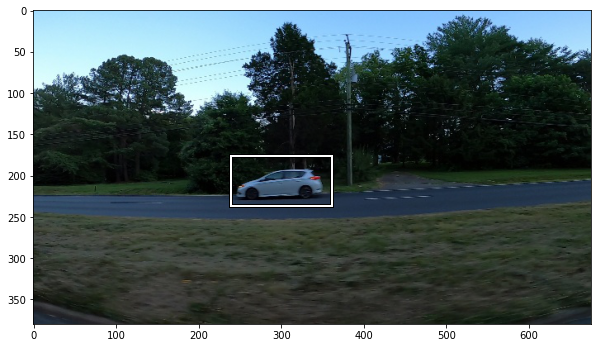

[1.]


In [24]:
cars_train_ds.show_image(2)

# Effdet Model

In [4]:
from effdet import create_model

In [ ]:
# to know more what more pretrained models you can use, see here https://github.com/rwightman/efficientdet-pytorch/blob/9cb43186711d28bd41f82f132818c65663b33c1f/effdet/config/model_config.py
# 'tf_efficientdet_lite0' is one of the lightest model, you can use others

In [69]:
IMAGE_SIZE=512
model = create_model('tf_efficientdet_lite0' , bench_task='train' , num_classes= 1 , image_size=(IMAGE_SIZE,IMAGE_SIZE),bench_labeler=True,pretrained=True)
model = model.to(device)

# Dataset & DataLoader

In [25]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


def get_train_transforms(target_img_size=512):
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )


def get_valid_transforms(target_img_size=512):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )

In [26]:
from torch.utils.data import Dataset

class EfficientDetDataset(Dataset):
    def __init__(
        self, dataset_adaptor, transforms=get_valid_transforms()
    ):
        self.ds = dataset_adaptor
        self.transforms = transforms

    def __getitem__(self, index):
        (
            image,
            pascal_bboxes,
            class_labels,
            image_id,
        ) = self.ds.get_image_and_labels_by_idx(index)

        sample = {
            "image": np.array(image, dtype=np.float32),
            "bboxes": pascal_bboxes,
            "labels": class_labels,
        }

        sample = self.transforms(**sample)
        sample["bboxes"] = np.array(sample["bboxes"])
        image = sample["image"]
        labels = sample["labels"]

        _, new_h, new_w = image.shape
        sample["bboxes"][:, [0, 1, 2, 3]] = sample["bboxes"][
            :, [1, 0, 3, 2]
        ]  # convert to yxyx

        target = {
            "bboxes": torch.as_tensor(sample["bboxes"], dtype=torch.float32),
            "labels": torch.as_tensor(labels),
            "image_id": torch.tensor([image_id]),
            "img_size": (new_h, new_w),
            "img_scale": torch.tensor([1.0]),
        }

        return image, target, image_id

    def __len__(self):
        return len(self.ds)

In [27]:
def collate_fn(batch):
        images, targets, image_ids = tuple(zip(*batch))
        images = torch.stack(images)
        images = images.float()

        boxes = [target["bboxes"].float() for target in targets]
        labels = [target["labels"].float() for target in targets]
        img_size = torch.tensor([target["img_size"] for target in targets]).float()
        img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

        annotations = {
            "bbox": boxes,
            "cls": labels,
            "img_size": img_size,
            "img_scale": img_scale,
        }

        return images, annotations, targets, image_ids

In [29]:
train_dataset = EfficientDetDataset(
            dataset_adaptor=cars_train_ds, transforms=get_train_transforms(target_img_size=512)
        )
train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=2,
            shuffle=True,
            pin_memory=True,
            drop_last=True,
            num_workers=min(2, os.cpu_count()),
            collate_fn=collate_fn,
        )

In [70]:
images, anns, _, _ = next(iter(train_loader))
images = images.to(device)
print(anns)
anns = {
    'bbox' : [tensor.to(device) for tensor in anns['bbox']],
    'cls' : [tensor.to(device) for tensor in anns['cls']],
    'img_size' : anns['img_size'].to(device),
    'img_scale' : anns['img_scale'].to(device)
}
model(images, anns)

{'bbox': [tensor([[254.6409,   0.0000, 308.6744,  52.2373]]), tensor([[244.7568, 182.6454, 306.6975, 274.1534],
        [245.4157, 363.8090, 291.5418, 435.6816]])], 'cls': [tensor([1.]), tensor([1., 1.])], 'img_size': tensor([[512., 512.],
        [512., 512.]]), 'img_scale': tensor([1., 1.])}


{'loss': tensor(1.4739, device='cuda:0', grad_fn=<AddBackward0>),
 'class_loss': tensor(1.2901, device='cuda:0', grad_fn=<SumBackward1>),
 'box_loss': tensor(0.0037, device='cuda:0', grad_fn=<SumBackward1>)}

In [76]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)

In [77]:
train_iter = tqdm(train_loader)
model.train()
for (images, anns, _, _) in train_iter:
    images = images.to(device)
    anns = {
        'bbox' : [tensor.to(device) for tensor in anns['bbox']],
        'cls' : [tensor.to(device) for tensor in anns['cls']],
        'img_size' : anns['img_size'].to(device),
        'img_scale' : anns['img_scale'].to(device)
    }
    losses = model(images, anns)
    loss = losses['loss']
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_iter.set_description(f'loss {loss.item():.4f}')

  0%|          | 0/177 [00:00<?, ?it/s]

In [81]:
torch.save(model.model.state_dict(), 'trained_effdet')

In [84]:
pred_model = create_model('tf_efficientdet_lite0' , bench_task='predict' , num_classes= 1 , image_size=(IMAGE_SIZE,IMAGE_SIZE),
                          bench_labeler=True,
                          checkpoint_path='./trained_effdet',
                          pretrained=False)
pred_model = pred_model.to(device)

In [85]:
with torch.no_grad():
    images, anns, _, _ = next(iter(train_loader))
    images = images.to(device)
    print(anns)
    anns = {
        'bbox' : [tensor.to(device) for tensor in anns['bbox']],
        'cls' : [tensor.to(device) for tensor in anns['cls']],
        'img_size' : anns['img_size'].to(device),
        'img_scale' : anns['img_scale'].to(device)
    }
    model.eval()
    out = pred_model(images)
    print(out.shape)

{'bbox': [tensor([[243.3368, 272.2214, 286.4456, 331.8864],
        [231.3990, 112.6176, 290.4249, 181.9781]]), tensor([[268.4788, 126.7033, 324.4891, 205.2446]])], 'cls': [tensor([1., 1.]), tensor([1.])], 'img_size': tensor([[512., 512.],
        [512., 512.]]), 'img_scale': tensor([1., 1.])}
torch.Size([2, 100, 6])


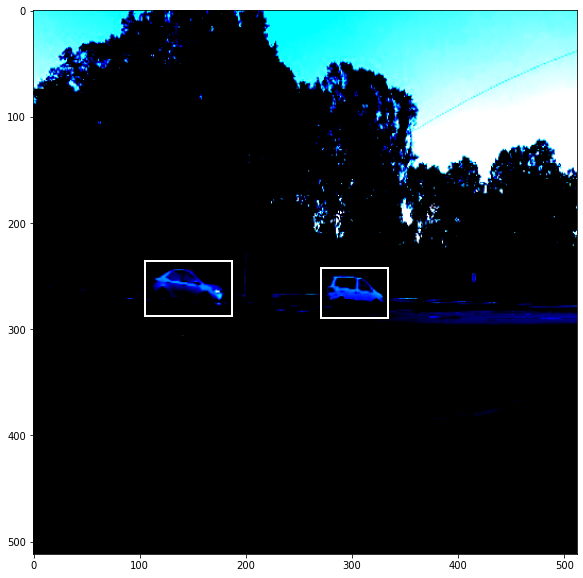

In [88]:
img_index = 0
show_image(images[img_index].detach().cpu().numpy().transpose(1, 2, 0), out[img_index, :2, :4].detach().cpu().numpy())

# Training

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_one_epoch(train_loader,model,optimizer,e,epochs,scheduler):
    losses = AverageMeter()
    c_losses = AverageMeter()
    b_losses = AverageMeter()
    model.train()
    global_step = 0
    loop = tqdm(enumerate(train_loader),total = len(train_loader))
    
    for step,batch in loop:
        images, ann, _, image_ids = batch 
        batch_size = len(image_ids)
        images = images.to(device)
        target = {}
        target["bbox"] = [a.to(device) for a in ann['bbox']]
        target["cls"] = [a.to(device) for a in ann["cls"]]
        target["img_scale"] = (
            torch.tensor([1] * batch_size).float().to(device)
        )
        target["img_size"] = (
            torch.tensor( ann["img_size"]).to(device).float()
        )
        
        output = model(images , target)
        loss = output['loss']
        c_loss = output['class_loss']
        b_loss = output['box_loss']
     
        losses.update(loss.item(), batch_size)
        c_losses.update(c_loss.item(), batch_size)
        b_losses.update(b_loss.item(), batch_size)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


        scheduler.step()
        global_step += 1
        
        loop.set_description(f"Epoch {e+1}/{epochs}")
        loop.set_postfix(loss = loss.item(), stage = 'train')
        
        
    return losses.avg, c_losses.avg , b_losses.avg

In [ ]:
def val_one_epoch(train_loader,model,e,epochs):
    losses = AverageMeter()
    c_losses = AverageMeter()
    b_losses = AverageMeter()
    model.eval()
    global_step = 0
    loop = tqdm(enumerate(train_loader),total = len(train_loader))
    
    for step,batch in loop:
        images, ann, _, image_ids = batch 
        batch_size = len(image_ids)
        images = images.to(device)
        target = {}
        target["bbox"] = [a.to(device) for a in ann['bbox']]
        target["cls"] = [a.to(device) for a in ann["cls"]]
        target["img_scale"] = (
            torch.tensor([1] * batch_size).float().to(device)
        )
        target["img_size"] = (
            torch.tensor( ann["img_size"]).to(device).float()
        )
        
        with torch.no_grad():
            output = model(images , target)
        loss = output['loss']
        c_loss = output['class_loss']
        b_loss = output['box_loss']
     
        losses.update(loss.item(), batch_size)
        c_losses.update(c_loss.item(), batch_size)
        b_losses.update(b_loss.item(), batch_size)
  

        global_step += 1
        
        loop.set_description(f"Epoch {e+1}/{epochs}")
        loop.set_postfix(loss = loss.item(), stage = 'val')
        
        
    return losses.avg, c_losses.avg , b_losses.avg

In [ ]:
def fit(m,fold_n ,train_bs=12, val_bs = 24):
    
    
    train_data= df[df.fold != fold_n]
    val_data  = df[df.fold == fold_n]
    
    train_ds =DataAdaptor(train_data.reset_index(drop=True))
    val_ds = DataAdaptor(val_data.reset_index(drop=True))
    
    train_data= CotsData(train_ds ,train_aug() )
    val_data  = CotsData(val_ds ,val_aug() )
    
    
    train_loader =DataLoader(
            train_data,
            batch_size=train_bs,
            shuffle=True,
            pin_memory=True,
            drop_last=True,
            num_workers=4,
            collate_fn=collate_fn,)
    
    valid_loader =DataLoader(
            val_data,
            batch_size=val_bs ,
            shuffle=False,
            drop_last=False,
            num_workers=4,
            collate_fn=collate_fn,)
   
    optimizer = optim.AdamW(m.parameters(), lr= 2e-4, weight_decay = 1e-6)
    epochs= 5
    warmup_epochs = 2
    num_train_steps = math.ceil(len(train_loader))
    num_warmup_steps= num_train_steps * warmup_epochs
    num_training_steps=int(num_train_steps * epochs)
    sch = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps = num_warmup_steps,num_training_steps =num_training_steps) 
    
    loop = range(epochs)
    for e in loop:
        
        total_loss,class_loss,box_loss = train_one_epoch(train_loader,m,optimizer,e,epochs,sch)
    
        print(f'For epoch {e+1}/{epochs}')
        print(f'average total_loss {total_loss}')
        print(f'average class_loss {class_loss}')
        print(f'average box_loss {box_loss}' )
        
        v_total_loss,v_class_loss,v_box_loss = val_one_epoch(valid_loader,m,e,epochs)
    
        print(f'For epoch {e+1}/{epochs}')
        print(f'average val total_loss {v_total_loss}')
        print(f'average val class_loss {v_class_loss}')
        print(f'average val box_loss {v_box_loss}' )
        
        torch.save(m.state_dict(),OUTPUT_DIR+ f'Fold {fold_n} model with val loss {v_total_loss}.pth') 

In [ ]:
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [ ]:
model= model.to(device)
fit(model,0)

# References
1. https://medium.com/data-science-at-microsoft/training-efficientdet-on-custom-data-with-pytorch-lightning-using-an-efficientnetv2-backbone-1cdf3bd7921f
2. https://www.kaggle.com/shonenkov/training-efficientdet/notebook
3. https://www.kaggle.com/julian3833/reef-starter-torch-fasterrcnn-train-lb-0-416/notebook
4. https://github.com/benihime91/SIIM-COVID19-DETECTION-KAGGLE/blob/main/net-det/train.py
5. Most importantly thanks to this https://github.com/rwightman/efficientdet-pytorch

Infer coming soon(I guess)